In [1]:
import os, sys
cwd = os.path.abspath('')
root_dir = os.path.dirname(cwd)
if not root_dir in sys.path: sys.path.append(root_dir)

In [2]:
import time
from typing import List
import jax.config
import jax.numpy as jnp
import numpy as np
from ase import units
from jax import jit, lax
from jax_md import space, energy, simulate
from jax_md.simulate import NVEState
jax.config.update("jax_enable_x64", True)

import jax_utils
from ase.atoms import Atoms
from ase.build import bulk
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary
from ase.calculators.lj import LennardJones
from ase.md import VelocityVerlet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(actual, expected):
    return sqrt(mean_squared_error(actual, expected))

### Initialization

In [3]:
def initialize_cubic_argon(multiplier=5, sigma=3.40, epsilon=0.01042, rc=10.54, ro=6.0, temperature_K=30) -> Atoms:
    atoms = bulk("Ar", cubic=True) * [multiplier, multiplier, multiplier]
    MaxwellBoltzmannDistribution(atoms, temperature_K=temperature_K)
    Stationary(atoms)
    atoms.calc = LennardJones(sigma=sigma, epsilon=epsilon, rc=rc, ro=ro, smooth=True)
    return atoms

sigma = 3.40
epsilon = 0.01042
ro = 6.0
rc = 10.54
dt = 5 * units.fs

### ASE NVE

In [4]:
def run_ase_nve(atoms: Atoms, steps: int, batch_size: int):
    positions = []
    i = 0

    dyn = VelocityVerlet(atoms, timestep=dt)
    
    while i < steps:
            i += batch_size

            dyn.run(batch_size)
            positions += [atoms.get_positions(wrap=True)]
            
    return np.array(positions)

### JAX-MD NVE

In [12]:
def get_initial_nve_state(atoms: Atoms) -> NVEState:
    R = jnp.float32(atoms.get_positions(wrap=True))
    V = jnp.float32(atoms.get_velocities())
    forces = jnp.float32(atoms.get_forces())
    masses = jnp.float32(atoms.get_masses()[0])
    return NVEState(R, V, forces, masses)

def run_nve(atoms: Atoms, steps: int, batch_size: int):

    def step_fn(i, state):
        state, neighbors = state
        neighbors = neighbor_fn(state.position, neighbors)
        state = apply_fn(state, neighbor=neighbors)
        return state, neighbors

    batch_times = []
    positions = []

    # setup displacement
    box = jnp.float32(atoms.get_cell().array)
    displacement_fn, shift_fn = space.periodic_general(box, fractional_coordinates=False)

    # normalize LJ parameters and setup NL energy function
    normalized_ro = ro / sigma
    normalized_rc = rc / sigma
    neighbor_fn, energy_fn = energy.lennard_jones_neighbor_list(displacement_fn, box,
                                                                sigma=sigma,
                                                                epsilon=epsilon,
                                                                r_onset=normalized_ro,
                                                                r_cutoff=normalized_rc,
                                                                dr_threshold=1 * units.Angstrom)

    # compute initial neighbor list
    R = jnp.float32(atoms.get_positions(wrap=True))
    neighbors = neighbor_fn(R, extra_capacity=100)

    # compute initial state & setup NVE
    state = get_initial_nve_state(atoms)
    _, apply_fn = simulate.nve(energy_fn, shift_fn, dt=dt)

    # run MD loop
    i = 0
    while i < steps:
        state, neighbors = lax.fori_loop(0, batch_size, step_fn, (state, neighbors))

        if neighbors.did_buffer_overflow:
            neighbors = neighbor_fn(state.position)
            print("Steps {}/{}: Neighbor list overflow, recomputing...".format(i, steps))
            continue    
            
        state.position.block_until_ready()            
        positions += [state.position]
        i += batch_size

    return np.array(positions)

In [6]:
from asax.lj import LennardJones as asaxLennardJones

def run_asax_nve(atoms: Atoms, steps: int, batch_size: int):
    positions = []
    i = 0
    
    atoms.calc = asaxLennardJones(epsilon, sigma, rc, ro, stress=False, dr_threshold=1 * units.Angstrom)
    dyn = VelocityVerlet(atoms, timestep=dt)
    
    while i < steps:
            i += batch_size

            dyn.run(batch_size)
            positions += [atoms.get_positions(wrap=True)]
            
    return np.array(positions)

In [7]:
def plot_rmse(steps: int, positions_1, positions_2):
    x = list(range(1, steps + 1, 1))
    y = [rmse(pos1, pos2) for pos1, pos2 in zip(positions_1, positions_2)]
    plt.plot(x, y)

## RMSE between two ASE simulations

NaN values:
False
False


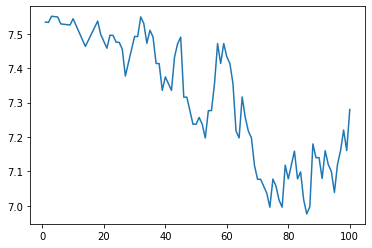

In [8]:
steps = 1000
batch_size = 1

atoms_1 = initialize_cubic_argon(multiplier=8)
atoms_2 = initialize_cubic_argon(multiplier=8)

if not np.array_equal(atoms_1.get_positions(), atoms_2.get_positions()):
    raise RuntimeError

ase_positions_1 = run_ase_nve(atoms_1, steps, batch_size)
ase_positions_2 = run_ase_nve(atoms_2, steps, batch_size)

if np.array_equal(atoms_1.get_positions(), atoms_2.get_positions()):
    raise RuntimeError
    
print("NaN values:")
print(np.isnan(ase_positions_1).all())
print(np.isnan(ase_positions_2).all())

plot_rmse(steps, ase_positions_1, ase_positions_2)

### ASE vs. JAX-MD

NaN values:
False
False


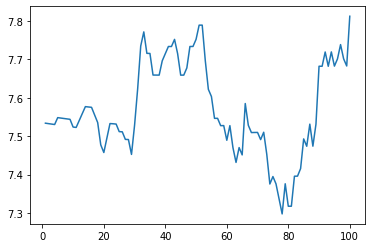

In [13]:
steps = 1000
batch_size = 1

ase_atoms = initialize_cubic_argon(multiplier=8)
jax_atoms = initialize_cubic_argon(multiplier=8)

if not np.array_equal(ase_atoms.get_positions(), jax_atoms.get_positions()):
    raise RuntimeError

ase_positions = run_ase_nve(ase_atoms, steps, batch_size)
jax_positions = run_nve(jax_atoms, steps, batch_size)

if np.array_equal(ase_atoms.get_positions(), jax_atoms.get_positions()):
    raise RuntimeError

print("NaN values:")
print(np.isnan(ase_positions).all())
print(np.isnan(jax_positions).all())
    
plot_rmse(steps, ase_positions, jax_positions)

### ASE vs. ASAX

NaN values:
False
False


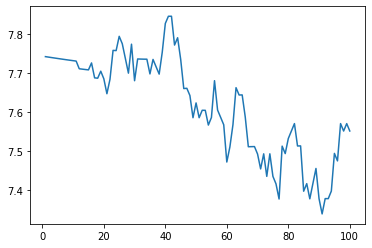

In [14]:
steps = 1000
batch_size = 1

ase_atoms = initialize_cubic_argon(multiplier=8)
asax_atoms = initialize_cubic_argon(multiplier=8)

if not np.array_equal(ase_atoms.get_positions(), asax_atoms.get_positions()):
    raise RuntimeError

ase_positions = run_ase_nve(ase_atoms, steps, batch_size)
asax_positions = run_asax_nve(jax_atoms, steps, batch_size)

if np.array_equal(ase_atoms.get_positions(), asax_atoms.get_positions()):
    raise RuntimeError

print("NaN values:")
print(np.isnan(ase_positions).all())
print(np.isnan(asax_positions).all())

plot_rmse(steps, ase_positions, asax_positions)

In [ ]:
# TODO: check total energy, kinetic energy, energy conservation